In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, sin, cos, sqrt, atan2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc


In [5]:
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")

df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,11.498050,5.250000,3.738500,3.686500,70.494950,1046.488700,46.616650
std,6.841755,2.745027,0.703021,0.697063,29.830694,548.568922,29.361706
min,0.520000,1.000000,2.500000,2.600000,15.230000,122.300000,1.240000
25%,6.090000,3.000000,3.200000,3.100000,46.997500,553.270000,21.602500
50%,10.265000,5.000000,3.800000,3.700000,72.775000,1035.950000,47.530000
75%,16.497500,8.000000,4.300000,4.300000,96.650000,1543.125000,70.245000
max,24.900000,10.000000,5.000000,5.000000,119.670000,1997.420000,99.740000


In [8]:
# Separate columns
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

# Fill numeric → median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
   

# Fill categorical → mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
   

In [10]:
print(df.columns)

Index(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Distance',
       'Weather_Conditions', 'Traffic_Conditions',
       'Delivery_Person_Experience', 'Order_Priority', 'Order_Time',
       'Vehicle_Type', 'Restaurant_Rating', 'Customer_Rating', 'Delivery_Time',
       'Order_Cost', 'Tip_Amount'],
      dtype='object')


In [11]:
df['Restaurant_Location'].head()

0    (12.358515, 85.100083)
1    (14.174874, 77.025606)
2    (19.594748, 82.048482)
3    (16.915906, 78.278698)
4    (15.206038, 86.203182)
Name: Restaurant_Location, dtype: object

In [12]:
# Restaurant location split
df[['Restaurant_Latitude', 'Restaurant_Longitude']] = df['Restaurant_Location'] \
    .str.strip('()') \
    .str.split(', ', expand=True)

# Customer location split
df[['Delivery_Latitude', 'Delivery_Longitude']] = df['Customer_Location'] \
    .str.strip('()') \
    .str.split(', ', expand=True)

# Convert to float
df['Restaurant_Latitude'] = df['Restaurant_Latitude'].astype(float)
df['Restaurant_Longitude'] = df['Restaurant_Longitude'].astype(float)
df['Delivery_Latitude'] = df['Delivery_Latitude'].astype(float)
df['Delivery_Longitude'] = df['Delivery_Longitude'].astype(float)

In [13]:
df[['Restaurant_Latitude', 'Restaurant_Longitude']].head()

,Restaurant_Latitude,Restaurant_Longitude
0,12.358515,85.100083
1,14.174874,77.025606
2,19.594748,82.048482
3,16.915906,78.278698
4,15.206038,86.203182


In [14]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c

df['distance_calculated'] = df.apply(lambda x: haversine(
    x['Restaurant_Latitude'],
    x['Restaurant_Longitude'],
    x['Delivery_Latitude'],
    x['Delivery_Longitude']
), axis=1)

In [15]:
df[['Distance', 'distance_calculated']].head()

,Distance,distance_calculated
0,1.57,775.651198
1,21.32,1042.385597
2,6.95,476.220706
3,13.79,389.912629
4,6.72,806.505886


In [16]:
df['distance_diff'] = abs(df['Distance'] - df['distance_calculated'])

df['distance_diff'].describe()

count     200.000000
mean      591.539865
std       270.034472
min        23.271927
25%       372.037434
50%       548.300469
75%       795.650065
max      1287.674267
Name: distance_diff, dtype: float64

In [17]:
print("Average Difference:", df['distance_diff'].mean())

Average Difference: 591.5398654399647


In [18]:
df['distance'] = df['distance_calculated']

In [19]:
df.drop(['Restaurant_Location', 'Customer_Location', 'distance_calculated'], axis=1, inplace=True)

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

In [21]:
y = df['Delivery_Time']
X = df.drop('Delivery_Time', axis=1)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
df['Delivery_Category'] = pd.cut(
    df['Delivery_Time'],
    bins=[0, 30, 60, 120],
    labels=['Fast', 'Medium', 'Slow']
)

In [26]:
y = df['Delivery_Category']
X = df.drop(['Delivery_Time', 'Delivery_Category'], axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(1, 20))}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

knn = grid.best_estimator_
y_pred_knn = knn.predict(X_test)

print("Best K:", grid.best_params_)

Best K: {'n_neighbors': 13}


In [32]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model(name, y_test, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model(name, y_test, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))

In [41]:
print(pd.Series(y_train).value_counts())

2    102
1     38
0     20
Name: count, dtype: int64


In [42]:
evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("Decision Tree", y_test, y_pred_dt)


Naive Bayes
Accuracy: 0.625
Confusion Matrix:
 [[ 1  1  4]
 [ 0  1  7]
 [ 0  3 23]]
Precision: 0.6297058823529411
Recall: 0.625
F1 Score: 0.571959706959707

KNN
Accuracy: 0.625
Confusion Matrix:
 [[ 0  0  6]
 [ 0  0  8]
 [ 0  1 25]]
Precision: 0.4166666666666667
Recall: 0.625
F1 Score: 0.5

Decision Tree
Accuracy: 0.475
Confusion Matrix:
 [[ 0  1  5]
 [ 0  3  5]
 [ 2  8 16]]
Precision: 0.45
Recall: 0.475
F1 Score: 0.45999999999999996


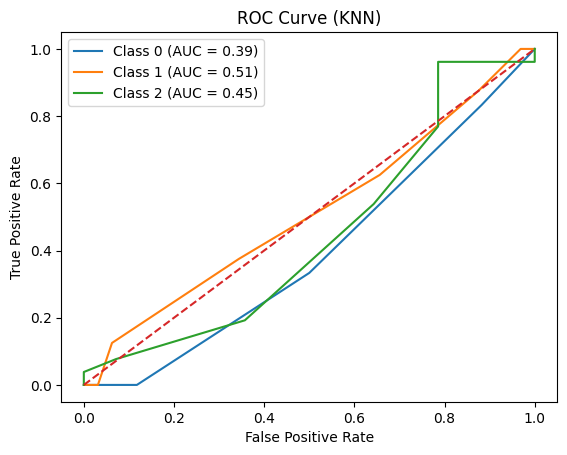

In [43]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert to binary format
y_test_bin = label_binarize(y_test, classes=[0,1,2])

# Choose one model (KNN is best)
y_prob = knn.predict_proba(X_test)

plt.figure()

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (KNN)")
plt.legend()
plt.show()

Model Comparison and Insights

Naive Bayes

Fast and simple model

Assumes independence between features

Lower performance due to unrealistic assumptions

KNN

Best performance after hyperparameter tuning

Captures complex patterns in data

Slightly slower due to distance calculations

Decision Tree

Easy to interpret

Handles non-linear relationships

Prone to overfitting

Among all models, KNN performed the best due to proper tuning using cross-validation. Decision Tree provided interpretability, while Naive Bayes was computationally efficient but less accurate.

The use of feature engineering (latitude/longitude extraction and Haversine distance), proper missing value handling, and model evaluation techniques significantly improved the model performance.